In [45]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
import os
import random
import shutil
import torchvision.datasets as datasets
import torchvision
import tqdm
import sklearn
import sklearn.datasets
from tensorboardX import SummaryWriter
from dataset import random_split

In [46]:
GPU_MODE = torch.cuda.is_available()
data_dir = 'data/'

In [ ]:
classes = ['healthy', 'Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 
           'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_mosaic_virus', 
          'Tomato_Yellow_Leaf_Curl_Virus']
binary_classes = ['healthy', 'non_healthy']

if os.path.exists(data_dir):
    shutil.rmtree(data_dir)
os.mkdir(data_dir)
os.mkdir(data_dir + 'test')
os.mkdir(data_dir + 'test/healthy')

shutil.copytree("original_dataset/healthy", data_dir + "train/healthy")
for i in range(int(len(os.listdir(data_dir + 'train/healthy')) * 0.2)): #testing parameter
    src = random.choice(os.listdir(data_dir + "train/healthy"))
    shutil.move(data_dir + "train/healthy/" + src, data_dir + "test/healthy/" + src)
    
os.mkdir(data_dir + 'train/non_healthy')
os.mkdir(data_dir + 'test/non_healthy')
for cls in tqdm.tqdm(list(classes[1:])):
    for i in range(133):
        src = random.choice(os.listdir("original_dataset/" + cls))
        shutil.copyfile("original_dataset/" + cls + '/' + src, data_dir + "train/non_healthy/" + src)#will become copytree
    for i in range(33):
        src = random.choice(os.listdir(data_dir + "train/non_healthy"))
        shutil.move(data_dir + "train/non_healthy/" + src, data_dir + "test/non_healthy/" + src)

In [38]:
batch_size = 16
data_transforms = {
        'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
        'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                      data_transforms[x]) for x in ['train', 'test']}

train_dataset_len = len(image_datasets['train'])
image_datasets['train'], image_datasets['val'] = random_split(image_datasets['train'], [train_dataset_len//2, train_dataset_len-train_dataset_len//2] )
    
"""trainloader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size,
                                         shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size,
                                         shuffle=True, num_workers=8)"""
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, 
                                              shuffle=True, num_workers=8) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
for i in ['train', 'val', 'test']:
    dataiter = iter(dataloaders[i])
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % binary_classes[labels[j]] for j in range(batch_size)))

In [42]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # 3 input image channel,
        # 6 output channel,
        # 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 4, 5)
        self.conv2 = nn.Conv2d(4, 6, 5)
        self.conv3 = nn.Conv2d(6, 16, 5)
        # an affine operation
        self.fc1 = nn.Linear(16 * 28 * 28, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        
    def forward(self, x):
        # max pooling over a (2, 2) windows
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
model = Model()
if GPU_MODE:
    model = model.cuda()
    
print(model)

Model(
  (conv1): Conv2d (3, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d (4, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d (6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=12544, out_features=120)
  (fc2): Linear(in_features=120, out_features=84)
  (fc3): Linear(in_features=84, out_features=2)
)


In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

num_epochs = 2
num_batches = 8
num_iterations = 0

log_dir = 'log/'
"""if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
writer = SummaryWriter(log_dir)"""

for epoch in tqdm.tqdm(list(range(num_epochs))):  # loop over the dataset multiple epochs

    for phase in ['train', 'val']:
        if phase == 'train':
            exp_lr_scheduler.step()
            model.train(True)  # Set model to training mode
        else:
            model.train(False)  # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        
        # iterate over the data
        for i, data in enumerate(dataloaders[phase], 0):

            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            if GPU_MODE:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad() # zero the gradient buffers

            # forward + loss
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            if phase == 'train':
                # backward + optimize
                loss.backward()
                optimizer.step() # does the update

            # statistics
            running_loss += loss.data[0] * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            if i % num_batches == num_batches - 1:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / num_batches))
                num_iterations += i
                writer.add_scalar(phase + '/loss', running_loss, num_iterations)
                running_loss = 0.0
            
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]
                
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        
print('Finished Training.')

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

[1,     8] loss: 10.733
[1,    16] loss: 10.588
[1,    24] loss: 10.552
[1,    32] loss: 10.547
[1,    40] loss: 10.548
[1,    48] loss: 10.530
[1,    56] loss: 10.759
[1,    64] loss: 10.569
train Loss: 0.0158 Acc: 0.6155
[1,     8] loss: 10.370
[1,    16] loss: 10.184
[1,    24] loss: 10.871
[1,    32] loss: 11.113
[1,    40] loss: 10.429
[1,    48] loss: 10.462
[1,    56] loss: 10.556
[1,    64] loss: 10.930
val Loss: 0.0155 Acc: 0.5992


 50%|██████████████████████████████████████████                                          | 1/2 [01:30<01:30, 90.99s/it]

[2,     8] loss: 10.746
[2,    16] loss: 10.610
[2,    24] loss: 10.759
[2,    32] loss: 10.217
[2,    40] loss: 11.000
[2,    48] loss: 10.275
[2,    56] loss: 10.236
[2,    64] loss: 10.178
train Loss: 0.0139 Acc: 0.6155
[2,     8] loss: 10.841
[2,    16] loss: 10.010
[2,    24] loss: 10.643
[2,    32] loss: 11.082
[2,    40] loss: 11.210
[2,    48] loss: 9.805
[2,    56] loss: 10.718
[2,    64] loss: 10.264
val Loss: 0.0127 Acc: 0.5992


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [03:02<00:00, 91.28s/it]


Finished Training.


GroundTruth:  healthy non_healthy healthy healthy non_healthy healthy non_healthy non_healthy non_healthy non_healthy healthy non_healthy healthy healthy healthy healthy


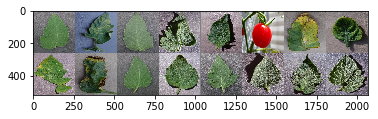

In [50]:
testloader = dataloaders['test']
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % binary_classes[labels[j]] for j in range(16)))

In [51]:
if GPU_MODE:
    outputs = model(Variable(images).cuda())
else:
    outputs = model(Variable(images))

_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % binary_classes[predicted.cpu()[j]]
                              for j in range(16)))

Predicted:  healthy healthy healthy healthy healthy healthy healthy healthy healthy healthy healthy healthy healthy healthy healthy healthy


In [52]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    if GPU_MODE:
        outputs = model(Variable(images).cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum()
    else:
        outputs = model(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 51 %


In [53]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
for data in testloader:
    images, labels = data
    if GPU_MODE:
        outputs = model(Variable(images).cuda())
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted.cpu() == labels).squeeze()
    else:
        outputs = model(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze() 
    for i in range(2):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

for i in range(2):
    print('Accuracy of %5s : %2d %%' % (binary_classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of healthy : 100 %
Accuracy of non_healthy :  0 %
